In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/joaquin/Documents/GitHub/skforecast'

In [1]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.utils.utils import align_series_and_exog_multiseries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset


%load_ext pyinstrument
%load_ext line_profiler

In [2]:
import pandas as pd

n = 5000
series = pd.DataFrame(
    {f"series_{i}": np.random.randint(1, 100, n) for i in range(1, 100)
    },
    index=pd.date_range(start="2023-01-01", periods=n, freq="D"),
)

freq = series.index.freq
series.index.name = "datetime"
series = series.reset_index()
series = pd.melt(series, id_vars="datetime", var_name="series_id", value_name="value")
series = series.groupby("series_id").apply(
    lambda x: x.set_index("datetime").asfreq("D"), include_groups=False
)
display(series)

exog = pd.DataFrame(
    {
        "exog_1": np.random.randint(1, 10, n),
        "exog_2": np.random.randint(1, 10, n),
    },
    index=pd.date_range(start="2023-01-01", periods=n, freq="D"),
)
exog.index.name= "datetime"
exog = [exog.assign(series_id=f"series_{i}") for i in range(1, 100)]
exog = pd.concat(exog)
exog = exog.set_index(["series_id", exog.index])
exog

value
series_id datetime         
series_1  2023-01-01     19
          2023-01-02      5
          2023-01-03     20
          2023-01-04     81
          2023-01-05     43
...                     ...
series_99 2036-09-04     85
          2036-09-05     43
          2036-09-06     58
          2036-09-07     65
          2036-09-08     14

[495000 rows x 1 columns]

exog_1  exog_2
series_id datetime                  
series_1  2023-01-01       6       5
          2023-01-02       3       5
          2023-01-03       3       2
          2023-01-04       4       8
          2023-01-05       9       9
...                      ...     ...
series_99 2036-09-04       9       9
          2036-09-05       6       3
          2036-09-06       3       6
          2036-09-07       9       9
          2036-09-08       2       6

[495000 rows x 2 columns]

In [3]:
%%timeit
unique_ids = series.index.levels[0]
indexes_freq = [
    series.loc[series_id].index.freq for series_id in unique_ids
]
indexes_freq = set(indexes_freq)


36.7 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
unique_freqs = (
    series.index.levels[0]  # series_id
    .map(lambda sid: series.loc[sid].index.freq)
    .unique()
    .tolist()
)

37 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
series_grouped = series.groupby(level=0, group_keys=False, sort=False)
series_grouped.apply(lambda x: x.index.get_level_values(1).freq)

""


In [6]:
%%timeit
series_grouped = series.groupby('series_id', sort=False)
series_grouped.apply(lambda x: x.index.levels[1].freq).unique().tolist()

74.3 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
forecaster = ForecasterRecursiveMultiSeries(regressor=LGBMRegressor(), lags=5, transformer_exog=StandardScaler())
forecaster.transformer_series_ = {k: StandardScaler() for k in series.index.get_level_values(0).unique()}
forecaster.differentiator_ = {k: None for k in series.index.get_level_values(0).unique()}

In [8]:
%%timeit
x_train, y_train = forecaster.create_train_X_y(
    series = series,
    exog=exog
)

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

224 ms ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:

def funt_to_profile(forecaster, series, exog):
    _ = forecaster._create_train_X_y(
                            series = series,
                            exog=exog
                        )

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, series, exog)

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1402                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `exog` has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `exog.index` is a DatetimeIndex with a frequency or a      │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1528                                                             │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Timer unit: 1e-09 s

Total time: 0.431399 s
File: /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: _create_train_X_y at line 960

Line #      Hits         Time  Per Hit   % Time  Line Contents
   960                                               def _create_train_X_y(
   961                                                   self,
   962                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   963                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
   964                                                   store_last_window: bool | list[str] = True,
   965                                               ) -> tuple[
   966                                                   pd.DataFrame,
   967                                                   pd.Series,
   968  

In [46]:
from skforecast.utils import check_preprocess_series

In [47]:
def funt_to_profile(series):
    check_preprocess_series(series=series)

%lprun -f check_preprocess_series funt_to_profile(series)

Timer unit: 1e-09 s

Total time: 0.197592 s

Could not find file <string>
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2                                           
     3                                           
     4                                           
     5                                           
     6                                           
     7                                           
     8                                           
     9                                           
    10                                           
    11                                           
    12                                           
    13                                           
    14                                           
    15              

In [21]:
series_ids = series.index.get_level_values(0).unique()
series_dict = {
    sid: series.loc[sid] for sid in series_ids
}
exog_dict = {
    sid: exog.loc[sid]for sid in series_ids
}

In [48]:
%%timeit
x_train, y_train = forecaster.create_train_X_y(
    series = series_dict,
    exog=exog_dict
)

NameError: name 'series_dict' is not defined

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:51:08  Samples:  1765
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.352     CPU time: 2.127
/   _/                      v5.0.1

Cell [26]

2.351 <module>  /tmp/ipykernel_159649/4187649707.py:1
`- 2.351 ForecasterRecursiveMultiSeries.create_train_X_y  skforecast/recursive/_forecaster_recursive_multiseries.py:1279
      [123 frames hidden]  skforecast, pandas, numpy, <built-in>...
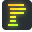

In [26]:
%%pyinstrument
x_train, y_train = forecaster.create_train_X_y(
    series = series_dict,
    exog=exog_dict
)